---
title: Basics - Fourier Transform
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

In MRI and MRS, we constantly move between the time domain (FID) and frequency domain (Spectrum), or between $k$-space and image space.

Standard `numpy.fft` functions place the zero-frequency (DC) component at the edges of the array, requiring manual `fftshift` operations. They also scale the signal amplitude by the number of points, which breaks energy conservation between domains.

The `xmris.fourier` module provides a modular approach to solve this:


1. **Pure Transforms (`fft` / `ifft`):** Performs orthogonal, N-dimensional transforms with NO shifting.
2. **Explicit Shifts (`fftshift` / `ifftshift`):** Safely rolls both the data and the coordinate axes.
3. **Centered Transforms (`fftc` / `ifftc`):** Convenience wrappers for symmetric data (like imaging) that shift data *before* and *after* the transform.

```mermaid
flowchart TD
    subgraph Centered Transform
        D2[(Input Data)] --> S1[ifftshift] --> F2[xmris.fft] --> S2[fftshift] --> O2[(Centered Output)]
    end
```

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xmris  # Registers the .xmr accessor  # noqa: F401

# Set a nice plotting style
plt.style.use("default")

## 1. 1D Signal: Time Domain to Frequency Domain
Let's generate a synthetic Free Induction Decay (FID) signal. Mathematically, a basic FID can be modeled as a complex exponential oscillating at a frequency offset $f_0$, decaying with a time constant $T_2^*$:

$$ S(t) = e^{-t/T_2^*} e^{i 2\pi f_0 t} $$

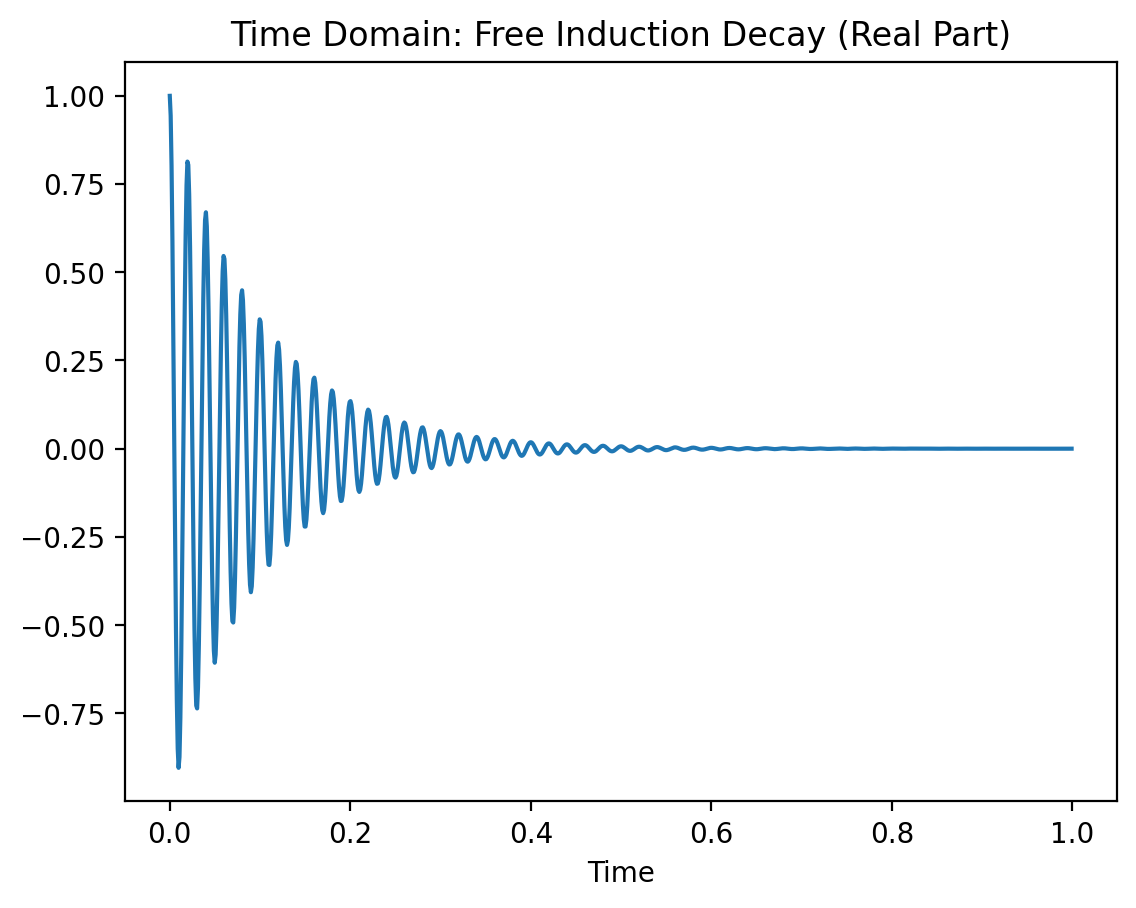

In [3]:
# Create a synthetic 1D FID (Time domain)
t = np.linspace(0, 1, 1024, endpoint=False)
f0 = 50.0  # 50 Hz frequency offset
t2_star = 0.1  # 100 ms decay

# Complex exponential decay
fid_data = np.exp(-t / t2_star) * np.exp(1j * 2 * np.pi * f0 * t)

da_fid = xr.DataArray(
    fid_data,
    dims=["Time"],
    coords={"Time": t},
    attrs={"ProtocolName": "PRESS_1H", "Units": "a.u."},
)

# Plot the real part of the FID
fig, ax = plt.subplots()

da_fid.real.plot(ax=ax)
ax.set_title("Time Domain: Free Induction Decay (Real Part)")
plt.show()

Now, we transform the signal. **Crucial:** Because this signal starts exactly at t=0, we *cannot* use the centered wrapper `fftc` (which applies an `ifftshift` to the input and would physically split our t=0 point to the center of the array, ruining the phase).

Instead, we use the pure `.xmr.fft()` followed by an explicit `.xmr.fftshift()`. The toolbox automatically calculates the reciprocal coordinate values (Hz) based on the input dwell time, and by providing `out_dim="Frequency"`, it conveniently renames the dimension for us in the same step!

*(Note: The `xmris.mrs` module provides a semantic wrapper `da.xmr.to_spectrum()` that does this exact method chain under the hood).*

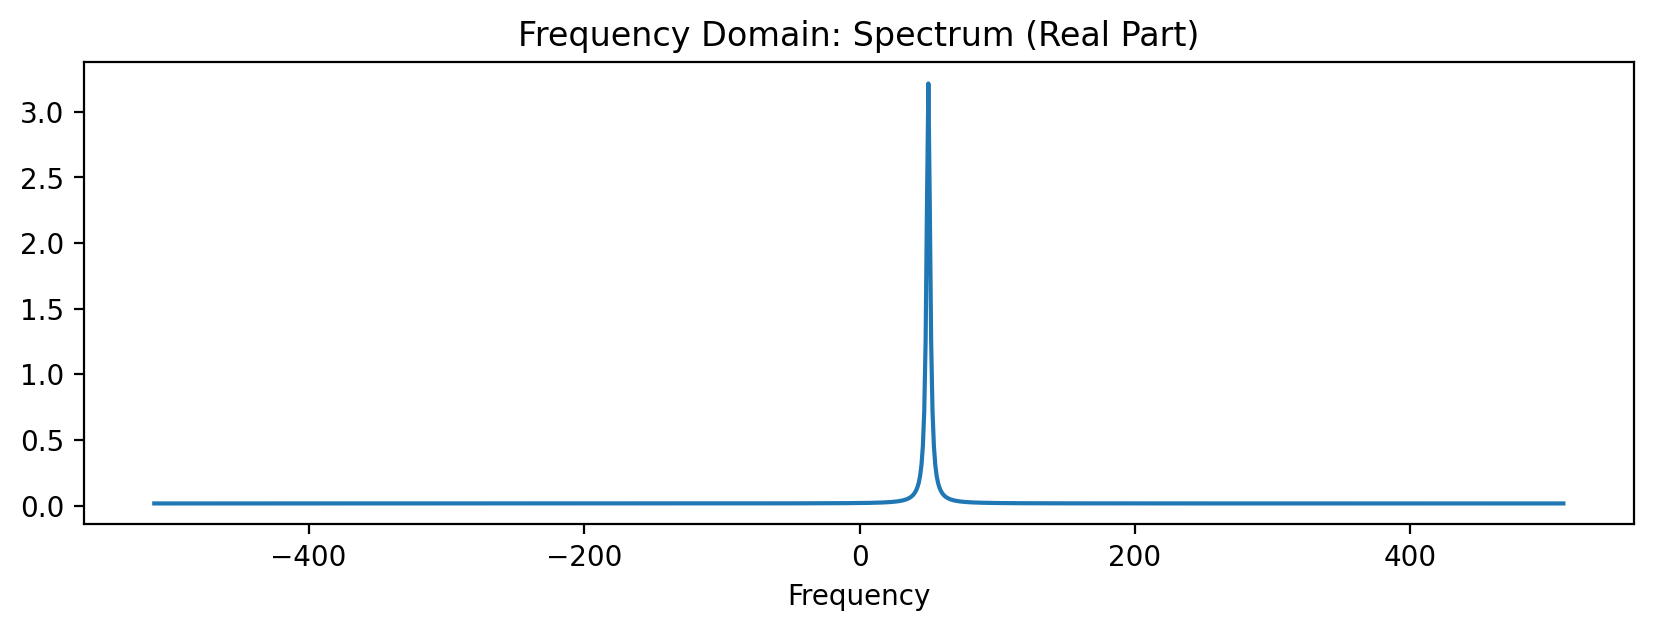

In [4]:
# Transform to Frequency Domain, calculate Hz axis, and center the output
da_spectrum = da_fid.xmr.fft(dim="Time", out_dim="Frequency").xmr.fftshift(
    dim="Frequency"
)

# Plot the real part of the spectrum
fig, ax = plt.subplots(figsize=(10, 3))
da_spectrum.real.plot(ax=ax)
ax.set_title("Frequency Domain: Spectrum (Real Part)")
plt.show()

In [5]:
# --- AUTOMATED TESTS (Pytest-nbmake) ---
# This cell is hidden in the MyST docs but executed in CI.

# 1. Metadata Preservation & Coordinate Transformation
assert "Frequency" in da_spectrum.dims, "Dimension was not renamed!"
assert "Time" not in da_spectrum.dims
assert da_spectrum.attrs["ProtocolName"] == "PRESS_1H"

# 2. Check the Math (Is the peak actually at 50 Hz?)
peak_idx = np.argmax(np.abs(da_spectrum.values))
peak_freq = da_spectrum.coords["Frequency"].values[peak_idx]
assert np.isclose(peak_freq, 50.0), f"Peak is at {peak_freq} Hz, expected 50 Hz!"

# 3. Parseval's Theorem (Energy Conservation via Ortho Normalization)
energy_time = np.sum(np.abs(da_fid.values) ** 2)
energy_freq = np.sum(np.abs(da_spectrum.values) ** 2)
assert np.isclose(energy_time, energy_freq), "FFT energy conservation failed!"

## 2. Imaging: 2D $k$-space to Image Space
The true power of `xarray` + `xmris` shines in multi-dimensional data. Let's create a synthetic 2D $k$-space. We will use a simple 2D rectangle, which analytically transforms into a 2D sinc function in the image domain.

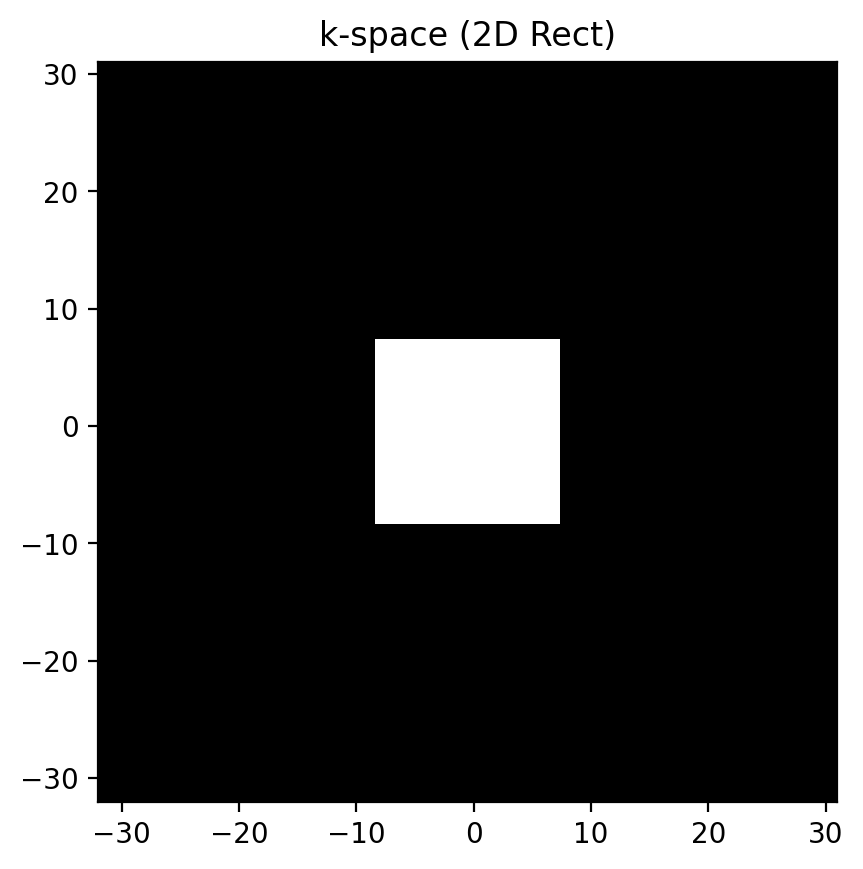

In [6]:
# Create a synthetic 2D k-space (64x64 matrix)
kspace_data = np.zeros((64, 64), dtype=complex)
# Create a 16x16 rect in the center
kspace_data[24:40, 24:40] = 1.0

da_kspace = xr.DataArray(
    kspace_data,
    dims=["kx", "ky"],
    coords={"kx": np.linspace(-32, 31, 64), "ky": np.linspace(-32, 31, 64)},
    attrs={"Sequence": "GRE"},
)

# Plot k-space magnitude
fig, ax = plt.subplots()
ax.imshow(np.abs(da_kspace.values), cmap="gray", extent=[-32, 31, -32, 31])
ax.set_title("k-space (2D Rect)")
plt.show()

Because imaging data is symmetrically sampled around the center of $k$-space, we *do* want to shift the input before the transform and shift the output after.

We use the convenience wrapper `.xmr.ifftc()` to do this automatically. By passing a **list of dimensions**, we perform a 2D inverse Fourier transform and seamlessly map `["kx", "ky"]` to `["x", "y"]` in a single, readable line of code.

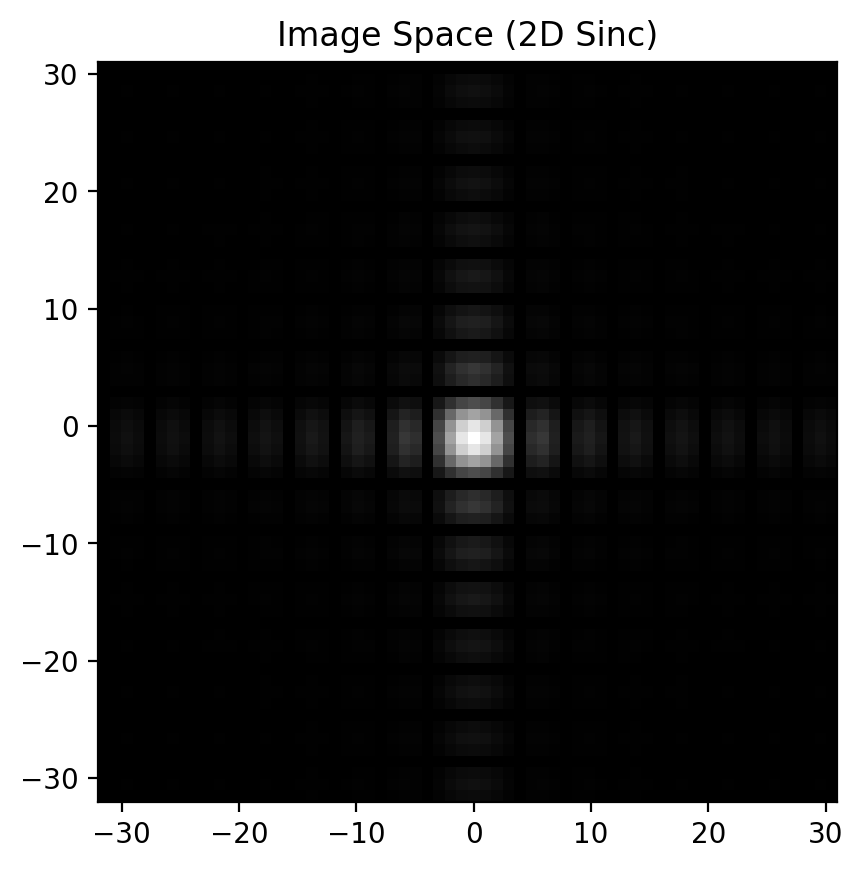

In [7]:
# Transform to Image Domain (2D IFFT with symmetric shifts) and rename dimensions
da_image = da_kspace.xmr.ifftc(dim=["kx", "ky"], out_dim=["x", "y"])

# Plot image domain magnitude
fig, ax = plt.subplots()
ax.imshow(np.abs(da_image.values), cmap="gray", extent=[-32, 31, -32, 31])
ax.set_title("Image Space (2D Sinc)")
plt.show()

In [8]:
# --- AUTOMATED TESTS (Pytest-nbmake) ---
# This cell is hidden in the MyST docs but executed in CI.

# 1. Coordinate mapping
assert da_image.dims == ("x", "y"), "Dimensions were not renamed to x and y!"

# 2. Centering Test
# Ensure the peak of the 2D Sinc is exactly in the center (index 32, 32)
peak_idx = np.unravel_index(np.argmax(np.abs(da_image.values)), da_image.shape)
assert peak_idx == (32, 32), "Image is not centered!"

# 3. Round-Trip Reversibility (IFFT -> FFT should yield original k-space)
da_reconstructed = da_image.xmr.fftc(dim=["x", "y"], out_dim=["kx", "ky"])
assert da_reconstructed.dims == ("kx", "ky"), "Dimensions did not revert to kx, ky!"
assert np.allclose(da_kspace.values, da_reconstructed.values), (
    "Round-trip transformation failed!"
)

print("All FFT / IFFT tests passed successfully! 🎉")

All FFT / IFFT tests passed successfully! 🎉
